In [1]:
import xlwings as xw
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import json

import XVA
import curvemanager

import QuantLib as ql
data_base = XVA.get_datamanager()
manager = XVA.CurveFactory(data_base)

### Processing

In [4]:
dfs = {}
date_handler = lambda year, month, day, **kwargs: "%02i%02i%04i" % (day, month,year)
for s in xw.books[0].sheets:
    dfs[s.name] = s.range('A1').options(pd.DataFrame, expand='table', index=False, dates=date_handler).value    

In [5]:
def exportJson(curve_name, curves):
    json_object  = json.dumps(data)
    with open(curve_name+".json", "w") as outfile:
        outfile.write(json_object)

In [6]:
def dropNones(d: dict) -> dict:
    r = d.copy()    
    for k, v in d.items():
        if v is None:
            del r[k]
    return r

In [7]:
def addPrices(r: dict) -> dict:
    d = r.copy()
    for k,v in r.items():
        if k in ['SPREAD','RATE','FXPOINTS','FXSPOT']:
            d[k] = prices_df[prices_df.TICKER==v].VALUE.iloc[0]
            d[k+'TICKER'] =v
    return d

In [8]:
curves = {}
exclude = ['CURVES','INDEX','PRICES','XCCYBASIS']
prices_df = dfs['PRICES']
curves_dfs = dfs['CURVES']
for curve in curves_dfs.CURVENAME:
    curve_config = curves_dfs[curves_dfs.CURVENAME==curve].iloc[0].to_dict()
    rate_helpers = []
    for s in xw.books[0].sheets:        
        if s.name not in exclude:
            tmp = dfs[s.name]            
            for r in tmp[tmp.CURVENAME==curve].T.to_dict().values():
                d = dropNones(r)
                d['TYPE'] = s.name
                d = addPrices(d)
                rate_helpers.append(d)
            curve_config['RATEHELPERS'] = rate_helpers
    curves[curve] = curve_config

In [9]:
indices = {}
indices_dfs = dfs['INDEX']
for index in indices_dfs.INDEXNAME:
    index_config = indices_dfs[indices_dfs.INDEXNAME==index].iloc[0].to_dict()
    indices[index] = index_config


In [10]:
REFDATE = '25082022'
REFDATE_DT = datetime(2022,8,25)
JSONEXPORT = True
dates = [REFDATE_DT+relativedelta(months=i) for i in range(0,24)]
dates_str = list(map(lambda d: d.strftime('%d%m%Y'), dates))

#### Test SOFR

In [11]:
TEST_CURVE = 'SOFR'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)
builder = curvemanager.CurveBuilder(data)
builder.build()

Building curve:  SOFR


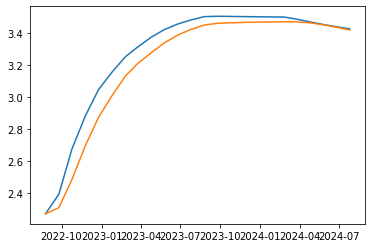

In [12]:
c = manager.build_curve(TEST_CURVE,REFDATE_DT)[0]
rates = [c.zeroRate(ql.Date(d.day,d.month,d.year),ql.Actual365Fixed(),ql.Continuous, ql.Annual).rate()*100 for d in dates]

try:
    values = builder.zeroRates(TEST_CURVE, dates_str, 'ACT365','CONTINUOUS','ANNUAL') 
    v = []
    for pair in values:
        v.append(pair*100)      
    plt.plot(dates,v)
    plt.plot(dates,rates)
except Exception as e:
    raise e

#### Test Collateral Curve

In [13]:
TEST_CURVE = 'CLP_COLLUSD'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)


In [14]:
builder.set(data)
builder.build()

Building curve:  COLLATERAL_USDCLP
Building curve:  LIBOR6M
Building curve:  LIBOR3M


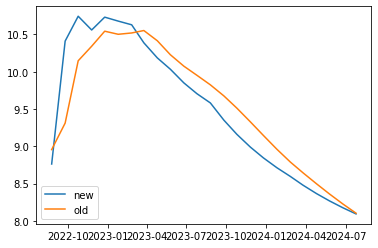

In [15]:
c = manager.build_curve('COLLATERAL_USDCLP',REFDATE_DT)[0]
rates = [c.zeroRate(ql.Date(d.day,d.month,d.year),ql.Actual365Fixed(),ql.Continuous, ql.Annual).rate()*100 for d in dates]
try:
    values = builder.zeroRates(TEST_CURVE, dates_str, 'ACT365','CONTINUOUS','ANNUAL') 
    v = []
    for pair in values:
        v.append(pair*100)      
    plt.plot(dates,v, label='new')
    plt.plot(dates,rates, label='old')
    plt.legend(loc='lower left')
except Exception as e:
    raise e

####  Test ICP

In [16]:
TEST_CURVE = 'ICP_ICAP'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)

In [17]:
builder.set(data)
builder.build()

Building curve:  ICP


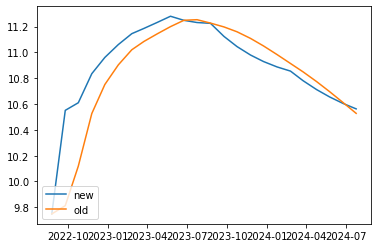

In [18]:
c = manager.build_curve('ICP',REFDATE_DT)[0]
rates = [c.zeroRate(ql.Date(d.day,d.month,d.year),ql.Actual360(),ql.Simple, ql.Annual).rate()*100 for d in dates]

try:
    values = builder.zeroRates(TEST_CURVE, dates_str, 'ACT360','SIMPLE','ANNUAL') 
    v = []
    for pair in values:
        v.append(pair*100)      
    plt.plot(dates,v, label='new')
    plt.plot(dates,rates, label='old')
    plt.legend(loc='lower left')
except Exception as e:
    raise e

In [19]:
pd.DataFrame({'dates':dates, 'rates':values}).head(20)

,dates,rates
0,2022-08-25,0.097487
1,2022-09-25,0.105510
2,2022-10-25,0.106100
3,2022-11-25,0.108350
4,2022-12-25,0.109608
5,2023-01-25,0.110605
6,2023-02-25,0.111450
7,2023-03-25,0.111858
8,2023-04-25,0.112329
9,2023-05-25,0.112800


#### Test LIBOR

In [20]:
TEST_CURVE = 'LIBOR3M'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)

In [21]:
builder.set(data)
builder.build()

In [22]:
TEST_CURVE = 'LIBOR6M'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)

In [23]:
builder.set(data)
builder.build()

In [24]:
TEST_CURVE = 'LIBOR12M'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)

In [25]:
builder.set(data)
builder.build()

### Test UF

In [26]:
TEST_CURVE = 'UF_COLLUSD'
data = {'REFDATE':REFDATE, 'CURVES':{TEST_CURVE: curves[TEST_CURVE]}, 'INDEX': {TEST_CURVE:indices[TEST_CURVE]}}
if JSONEXPORT: exportJson(TEST_CURVE, data)

In [27]:
builder.set(data)
builder.build()

In [28]:
c = manager.build_curve('COLLATERAL_USDUF',REFDATE_DT)[0]
rates = [c.zeroRate(ql.Date(d.day,d.month,d.year),ql.Actual360(),ql.Simple, ql.Annual).rate()*100 for d in dates]

try:
    values = builder.zeroRates(TEST_CURVE, dates_str, 'ACT360','SIMPLE','ANNUAL') 
    v = []
    for pair in values:
        v.append(pair*100)      
    plt.plot(dates,v, label='new') 
    plt.plot(dates,rates, label='old')
    plt.legend(loc='lower left')
except Exception as e:
    raise e

Building curve:  COLLATERAL_USDUF


RuntimeError: 1st iteration: failed at 18th alive instrument, pillar February 29th, 2024, maturity February 29th, 2024, reference date August 25th, 2022: root not bracketed: f[0.927521,1.03652] -> [nan,nan]